# OWF site location optimisation

* Optimise according to physical restraints (depth), and according to simulated performance across a range of sample days (energy potential of the site).

In [133]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
from platypus import NSGAII, NSGAIII, Problem, Real, nondominated
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from mpl_toolkits.basemap import Basemap
import joblib
from matplotlib import path
from shapely.geometry import Polygon
from descartes import PolygonPatch
import pylab as pl
from functools import reduce
import operator
import math
from scipy.spatial import distance
from shapely import affinity


In [134]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [135]:
class OWF(Problem):
    def __init__(self, lat_limits, lon_limits, data, map_polygon):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 8 (4 sets of lat and long to define bounding box)
        Nobjs: 3 (depth, wind potential of site, size of site, out-of-bounds (OOB) violations)
        #Nconstraints: 2 (depth and wind potential of site)
        """
        super(OWF, self).__init__(11, 4)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits

        lat_range = lat_limits[1] - lat_limits[0]
        lon_range = lon_limits[1] - lon_limits[0]

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            # corners are offset from center coordinates

            Real(-lon_range, 0),    # q1 lon
            Real(0, lat_range),     # q1 lat
            
            Real(0, lon_range),     # q2 lon
            Real(0, lat_range),     # q2 lat

            Real(0, lon_range),     # q3 lon
            Real(-lat_range, 0),    # q3 lat

            Real(-lon_range, 0),    # q4 lon
            Real(-lat_range, 0),    # q4 lat

            
        ]

        self.directions = [
            Problem.MAXIMIZE,  # maximise depth (all depths are negative)
            Problem.MAXIMIZE,  # maximise wind potential
            Problem.MINIMIZE,  # minimise area used
            Problem.MAXIMIZE,  # maximise intersection area
        ]

        # self.constraints = [
        #    "<=25",  # limited to depth of max 25m
        #    #">0",   # no constraints to wind potential
        # ]

        self.data = data

        self.map_polygon = map_polygon

    def evaluate(self, solution):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.

            q1_lat: latitude of the first point of the quadrilateral.
            q1_lon: longitude of the first point of the quadrilateral.
            q2_lat: latitude of the second point of the quadrilateral.
            q2_lon: longitude of the second point of the quadrilateral.
            q3_lat: latitude of the third point of the quadrilateral.
            q3_lon: longitude of the third point of the quadrilateral.
            q4_lat: latitude of the fourth point of the quadrilateral.
            q4_lon: longitude of the fourth point of the quadrilateral.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = x[1:3]
        q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
        
        # calculate corner coordinates from center and q offset
        q1_coord = [center[0] + q1[0], center[1] + q1[1]]
        q2_coord = [center[0] + q2[0], center[1] + q2[1]]
        q3_coord = [center[0] + q3[0], center[1] + q3[1]]
        q4_coord = [center[0] + q4[0], center[1] + q4[1]]

        # rotation corner coordinates by rotation angle
        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

        # define polygon as path
        polygon = path.Path(points)
        # get data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]


        shapely_polygon = Polygon(points).buffer(0)

        # rotate polygon by rotation angle about center coordinate
        shapely_polygon = affinity.rotate(shapely_polygon, rotation, origin=center)

        # calculate intersection area between map polygon and solution polygon
        intersection = self.map_polygon.intersection(shapely_polygon).area
        intersection = intersection / shapely_polygon.area * 100.0
        # print('Coverage: ', intersection / shapely_polygon.area*100, '%')

        # dataframe is empty, because no data at that location (out of bounds / too small), set depth and wind potential to -inf
        if data_polygon.empty:
            area = np.inf
            depth = -np.inf
            wind_potential = -np.inf

        else:
            area = shapely_polygon.area * 100

            # get average depth from bathymetric data polygon
            depth = data_polygon["Depth"].mean()

            # get average wind potential from wind data polygon
            wind_potential = data_polygon["Chi"].mean()

        # print(f'Depth: {depth:.2f}, Wind Potential: {wind_potential:.2f}, Area: {area:.2f}, Intersection: {intersection:.2f}')

        solution.objectives[:] = [
            depth,
            wind_potential,
            area,
            intersection,
        ]  # solution objective scores relative to depth and wind potential of site
        # solution.constraints[:] = [depth, wind_potential]   # can later search for feasible solutions, constrained by depth and wind potential


In [136]:
data = pd.read_csv("data/UK east coast.csv")

data_lat_range = (min(data["Lat"]), max(data["Lat"]))
data_lon_range = (min(data["Lon"]), max(data["Lon"]))

print(f"Latitude range: {data_lat_range}, Longitude range: {data_lon_range}")


Latitude range: (53.486257927, 54.8083537), Longitude range: (-0.5269085, 2.5571098)


In [137]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("data/UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

# swap columns (lon, lat) to (lat, lon)
polygon_np = polygon_np[:, [1, 0]]

map_polygon = Polygon(polygon_np)


In [138]:
# load the problem
problem = OWF(
    lat_limits=data_lat_range,
    lon_limits=data_lon_range,
    data=data,
    map_polygon=map_polygon,
)


In [139]:
# run the optimisation
algorithm = NSGAII(problem)
algorithm.run(10000)


In [140]:
nondominated_solutions = nondominated(algorithm.result)
Y = np.array([s.objectives for s in nondominated_solutions])


In [141]:
# convert results to pandas dataframe
results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Depth",
        "Wind Potential",
        "Area",
        "Intersection",
    ]
)

# read nondominated solutions into dataframe
for i, solution in enumerate(nondominated_solutions):
    results.loc[i] = [*solution.variables[:], *solution.objectives]

print(results)


      rotation  center_lon  center_lat    q1_lon    q1_lat    q2_lon  \
0   142.930221    0.431402   54.371074 -0.007219  0.002956  0.450592   
1   164.597621    1.059207   54.332852 -0.013119  0.001049  0.703722   
2   183.429792    2.555459   53.548404 -0.015963  0.002939  0.011158   
3   170.188868    2.372222   53.672679 -0.000081  0.006461  0.000649   
4   187.156614    2.505700   54.564111 -0.039800  0.892942  2.042430   
..         ...         ...         ...       ...       ...       ...   
95  173.126420    1.059207   53.498385 -0.015963  0.002939  0.000649   
96  172.527229    2.556908   53.667589 -0.000499  0.029129  0.633155   
97  117.416026    2.363890   53.553680 -0.004445  0.001975  0.067911   
98  190.282555    2.556908   53.613322 -0.002987  0.882172  1.035942   
99  158.503115    0.975675   53.496097 -0.031491  0.005178  0.372651   

      q2_lat    q3_lon    q3_lat    q4_lon    q4_lat      Depth  \
0   0.007573  0.001572 -0.001774 -0.019753 -0.030008 -60.606389   
1

In [142]:
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
# ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2])
# ax.set_xlabel('Depth')
# ax.set_ylabel('Wind Potential')
# ax.set_zlabel('Area')
# plt.show()


     rotation  center_lon  center_lat   q1_lon    q1_lat    q2_lon    q2_lat  \
0  184.718982    1.055379   53.488485 -0.04168  0.010351  0.196881  0.013383   

     q3_lon    q3_lat    q4_lon    q4_lat      Depth  Wind Potential  \
0  0.026644 -1.012481 -0.356266 -0.629193 -17.104545   -1.827911e+06   

        Area  Intersection  
0  30.483995     91.955192  


c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\shapely\affinity.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if origin == 'center':
c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\shapely\affinity.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif origin == 'centroid':
c:\Users\zacha\miniconda3\envs\py10\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


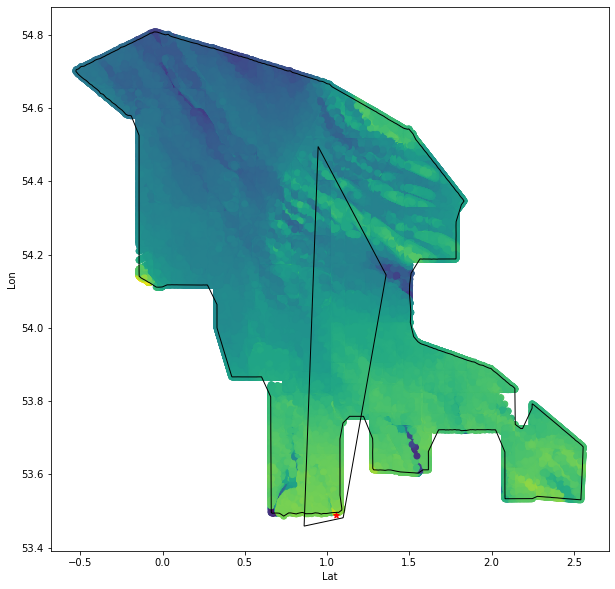

In [147]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# find the best solution
x = results.loc[results["Intersection"] >= 80]
x = x.loc[x["Area"] <= 50]
x = x.loc[x["Area"] >= 30]
x = x.loc[x["Wind Potential"] == x["Wind Potential"].min()]
x = x.reset_index(drop=True)
print(x)

x = x.to_numpy()[0]

# read solution into variables
rotation = x[0]
center = x[1:3]
q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]

# calculate corner coordinates from center and q offset
# REVERSE XY from LAT LON to LON LAT
q1_coord = [center[0] + q1[0], center[1] + q1[1]]
q2_coord = [center[0] + q2[0], center[1] + q2[1]]
q3_coord = [center[0] + q3[0], center[1] + q3[1]]
q4_coord = [center[0] + q4[0], center[1] + q4[1]]

# rotation corner coordinates by rotation angle
points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

polygon = Polygon(points)
# rotate polygon by rotation angle about center coordinate
polygon = affinity.rotate(polygon, rotation, origin=center)

map = ax.scatter(data["Lon"], data["Lat"], c=data["Depth"], cmap="viridis")
ax.scatter(center[0], center[1], c="r", marker="*")

patch = PolygonPatch(polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(patch)

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

ax.set_xlabel("Lat")
ax.set_ylabel("Lon")

plt.show()
